In [1]:
%load_ext autoreload
%autoreload 2

DATA_DIR = '../data/'

# Explore the columns of data and find outliers
import pandas as pd
import os
import os.path as osp
from typing import Optional
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../')

In [2]:
# Visualization libraries
from source.utils.visualization import *
SAVE_EXTENSION = '.pdf'
SAVE_DIR = '../figures/'

plot_kwargs = {
    "column" : "half",
    "nrows" : 1,
    "ncols" : 1,
    "usetex" : False
}
setup_plotting_icml2022(
    **plot_kwargs
    )

In [3]:
REFRESH_DATA = True
CHARTS_PATH = osp.join(DATA_DIR,'charts_processed.csv')
AUDIO_PATH = osp.join(DATA_DIR,'audio_features_processed.csv')

In [4]:
if REFRESH_DATA:

    # Load the datasets into dataframes. Read the date column as datetime.date
    charts_df = pd.read_csv(CHARTS_PATH, parse_dates=['date'])

charts_df['date'] = pd.to_datetime(charts_df['date'])

# Display the first few rows of the DataFrame to verify
charts_df.head()

,title,rank,date,artist,url,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988.0
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943.0
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865.0
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956.0


In [5]:
if REFRESH_DATA:
    # Load the audio features dataset
    audio_df = pd.read_csv(AUDIO_PATH)

    # Change the column-name of 'id' to 'track_id' to match the charts_df
    audio_df.rename(columns={'id': 'track_id'}, inplace=True)
    print(audio_df.head())


   acousticness  danceability  duration_ms  energy  instrumentalness  key  \
0       0.18700         0.852       195840   0.773          0.000030    8   
1       0.00431         0.663       259196   0.920          0.000017   11   
2       0.40000         0.761       222560   0.838          0.000000    4   
3       0.55100         0.508       205600   0.687          0.000003    0   
4       0.07600         0.899       234320   0.626          0.000000    6   

   liveness  loudness  mode  speechiness    tempo  time_signature  valence  \
0    0.1590    -2.921     0       0.0776  102.034               4    0.907   
1    0.1010    -4.070     0       0.2260   99.935               4    0.533   
2    0.1760    -3.073     0       0.0502   93.974               4    0.710   
3    0.1260    -4.361     1       0.3260  180.044               4    0.555   
4    0.0631    -4.228     0       0.2920   88.007               4    0.873   

                 track_id  
0  6mICuAdrwEjh6Y6lroV2Kg  
1  7DM4BPaS7

In [6]:
# For now only restrict the dataset to top200 charts for stream/ranking analysis.
charts_df = charts_df[charts_df["chart"] == "top200"]
charts_df["track_id"] = charts_df["url"].apply(lambda x: x.split("/")[-1])

# Stream proportions

In [7]:
import sys
sys.path.append("../")

from source.utils.regions import get_charts_by_date, get_charts_by_region,get_regional_charts_delta_rank

def get_chart_daily_feature_vector(charts_df : pd.DataFrame, audio_df : pd.DataFrame) -> pd.DataFrame:
    """
    Add the stream_proportion column to the charts_df DataFrame.
    """
    # Assert that only one region and date is given
    assert len(charts_df["region"].unique()) == 1

    charts_df["stream_proportion"] = charts_df["streams"] / charts_df["streams"].sum()

    # Join the audio_df to the charts_df
    charts_df = charts_df.merge(audio_df, on="track_id", how="left")

    # Drop the duplicate columns
    charts_df.drop_duplicates(subset=["track_id"], inplace=True)

    # Return the stream_proportion * audio_features
    audio_features_columns = audio_df.columns.drop(["track_id"])
    for col in audio_features_columns:
        charts_df[col] = charts_df["stream_proportion"] * charts_df[col]

    # Sum the audio features to get a single row
    audio_feature_vector = charts_df[audio_features_columns].sum(axis=0)

    # Return audio features as a vector
    return audio_feature_vector

In [8]:
test_df = get_charts_by_region(charts_df, "Germany")
test_df = get_charts_by_date(test_df, '2018-01-01')
get_chart_daily_feature_vector(test_df, audio_df)

acousticness             0.175804
danceability             0.716481
duration_ms         206886.780135
energy                   0.690703
instrumentalness         0.004930
key                      5.184878
liveness                 0.146220
loudness                -5.716778
mode                     0.504769
speechiness              0.113123
tempo                  117.072558
time_signature           3.985396
valence                  0.528297
dtype: float64

In [9]:
import tqdm
def collect_global_feature_vectors(charts_df : pd.DataFrame, audio_df : pd.DataFrame, date : str) -> pd.DataFrame:
    """
    From the charts, collect the audio feature vectors for each region and return a DataFrame.
    
    Parameters:
    - charts_df (pd.DataFrame): DataFrame containing the charts data.
    - audio_df (pd.DataFrame): DataFrame containing the audio feature data.
    - date (str): The date for which the feature vectors are collected.
    
    Returns:
    - pd.DataFrame: DataFrame containing the global feature vectors for each region.
    """

    unique_regions = charts_df["region"].unique()

    for i, region in tqdm.tqdm(enumerate(unique_regions)):
        if region.lower() == "global":
            continue
        region_df = get_charts_by_region(charts_df, region)
        region_df = get_charts_by_date(region_df, date)
        region_feature_vector = get_chart_daily_feature_vector(region_df, audio_df)
        if i == 0:
            global_feature_vectors_df = pd.DataFrame(region_feature_vector).T
        else:
            global_feature_vectors_df = global_feature_vectors_df.append(region_feature_vector, ignore_index=True)

    return global_feature_vectors_df

Calculating metrics for Brazil between 2017-01-01 and 2022-01-01: 100%|██████████| 4797/4797 [01:39<00:00, 48.33it/s]


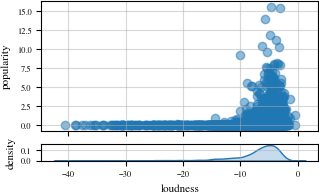

In [42]:
import seaborn as sns
from source.utils.regions import get_charts_by_date, get_charts_by_region,get_regional_charts_delta_rank, calculate_popularity_metrics

def plot_popularity_metrics(charts_df : pd.DataFrame,
                            audio_df : pd.DataFrame, 
                            region : str,
                            date_range : Tuple[str, str],
                            metric_column : str,
                            audio_feature_column : str,
                            delta_k : int = 200, save_dir : Optional[str] = None):

    if metric_column in ["delta_rank","streams"] :
        test_df = get_regional_charts_delta_rank(
            get_charts_by_region(charts_df,region=region),
            date_range,
            normalize_streams=False,
            
        )

        test_df_joined = test_df[['track_id',metric_column]].join(audio_df.set_index('track_id'), on='track_id').drop_duplicates(subset="track_id")

    elif metric_column in ["weighted_popularity", "popularity"]:
        test_df = calculate_popularity_metrics(
        get_charts_by_region(charts_df, region),
        date_range,
        delta_k = delta_k)

        test_df['weighted_popularity'] = test_df['popularity'] * test_df['average_stream_proportion']
        test_df_joined = test_df[['track_id',metric_column]].join(audio_df.set_index('track_id'), on='track_id').drop_duplicates(subset="track_id")

    # Create two subplots with different height ratios and shared x-axis
    fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [8, 1]}, sharex=True)

    # Scatter plot on the first subplot
    axs[0].scatter(test_df_joined[audio_feature_column],test_df_joined[metric_column], alpha=0.5)
    axs[0].set_ylabel(metric_column if metric_column != "weighted_popularity" else "popularity")
    axs[0].grid(alpha=0.5)

    # KDE plot on the second subplot
    sns.kdeplot(x=test_df_joined[audio_feature_column], ax=axs[1], shade=True, bw_adjust=.5)
    axs[1].set_xlabel(audio_feature_column)
    axs[1].set_ylabel("density")
    axs[1].grid(alpha=0.5)
    
    spearman_corr = spearmanr(test_df_joined[audio_feature_column], test_df_joined[metric_column])

    plt.savefig(os.path.join(save_dir, f"{audio_feature_column}_vs_{metric_column}_{region}.pdf"))

    
plot_kwargs = {
    "column" : "half",
    "nrows" : 1,
    "ncols" : 1,
    "usetex" : False
}
reset_plottings(**plot_kwargs)    
plot_popularity_metrics(
    charts_df,
    audio_df,
    region="Nicaragua",
    date_range=("2017-01-01", "2022-01-01"),
    metric_column="weighted_popularity",
    audio_feature_column="loudness",
    save_dir=SAVE_DIR
)
    